# 第四章 基础实战——FashionMNIST时装分类

<img src="./fashion-mnist-sprite.png" width="400" />  
  
经过前面三章内容的学习，我们完成了以下的内容：  
- 对PyTorch有了初步的认识
- 学会了如何安装PyTorch以及对应的编程环境
- 学习了PyTorch最核心的理论基础（张量&自动求导）
- 梳理了利用PyTorch完成深度学习的主要步骤和对应实现方式  
  
现在，我们通过一个基础实战案例，将第一部分所涉及的PyTorch入门知识串起来，便于大家加深理解。同时为后续的进阶学习打好基础。 
  
我们这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集（https://www.kaggle.com/zalando-research/fashionmnist ）。上图给出了FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。  
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为32\*32pixel，分属10个类别。  
  
下面让我们一起将第三章各部分内容逐步实现，来跑完整个深度学习流程。

In [1]:
!nvidia-smi  #gpu型号为p100

Fri Jun  3 10:33:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**首先导入必要的包**  

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

**配置训练环境和超参数**  


In [3]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# # 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 2     # 对于Windows用户，这里应设置为0，否则会出现多线程错误.如果是4的话，会出现warning    /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: 
                    # UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. 
                    # Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.cpuset_checked))
                    # gpu下的核心数是2，所以使用4时会有warning
LR = 1e-3
epochs = 25

第一种方式更简单，后续使用时只需要xxx.cuda()
第二种方式：xxx.to_device(device)

**数据读入和加载**  
这里同时展示两种方式:  
- 下载并使用PyTorch提供的内置数据集  
- 从网站下载以csv格式存储的数据，读入并转成预期的格式    
第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）  
第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要  
  
同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。
  
这些变换可以很方便地借助torchvision包来完成，这是PyTorch官方用于图像处理的工具库，上面提到的使用内置数据集的方式也要用到。PyTorch的一大方便之处就在于它是一整套“生态”，有着官方和第三方各个领域的支持。这些内容我们会在后续课程中详细介绍。

In [4]:
# 首先设置数据变换
from torchvision import transforms
# An MNIST-like dataset of 70,000 28x28 labeled fashion images
image_size = 28 #这里是为了更好的匹配使用的模型（应该也可以不使用28，可以试一下，看看acc），使用的模型是针对minist手写数字设计的，而minist数据集中华图片的大小就是28
data_transform = transforms.Compose([
    transforms.ToPILImage(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要，它已经帮助实现了这个操作。PILImag是pytorch内置的图片的形式
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [5]:
# ## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
# from torchvision import datasets

# train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)  # FashionMNIST可以换成pytorch中有的数据集，如MINIST 
# test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

In [6]:
# train_data

In [7]:
## 读取方式二：读入csv格式的数据，自行构建Dataset类
# csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):                            #向量形式转换为图片形式，继承官方的Dataset类
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)  # 得到所有的图片数据 #uint8是一个用于图像的数据格式，matplotlib提供了特殊的数据类型uint8(8位无符号整数），以此方式存储的图像称作8位图像。
        #unsigned char，数据范围在0~255之间，非常适合于存放图像数据。比如我们通过opencv读取一幅灰度影像，可以用一个uint8数组来保存灰度影像每个像素的灰度值。
        self.labels = df.iloc[:, 0].values
        
    def __len__(self):
        return len(self.images)   #图片个数
    
    def __getitem__(self, idx):              #很重要，决定了Dataset是怎样构建的。在self.images中得到的是所有的图像。idx默认从第一条到最后一条。逐个获得每张图片。一个image和一个label就是一个pair，组合的关系
        image = self.images[idx].reshape(28,28,1) #强行加了一个1，单通道
        label = int(self.labels[idx])          #self.images和self.labels是dataframe形式，使用时根据索引idx取出对应的数据
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)    #归一化
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_df = pd.read_csv("../input/ministfashion/fashion-mnist_train.csv") # 图片的表格形式
test_df = pd.read_csv("../input/ministfashion/fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)    #构建训练集（60000个样本）和测试集（10000个样本）
test_data = FMDataset(test_df, data_transform)
# 实现的目标就是将csv的每一行（一张图片，此处不包含标签）变成了有一个28*28*1的tensor


In [8]:
train_data.__len__()

60000

In [9]:
image_test,label_test = train_data.__getitem__(0)
print(image_test) # 一张图片，二维数组28*28
print(label_test) # tensor(2)，属于第2类

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902, 0.2000,
          0.5333, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000,

In [10]:
train_df # 1列label + 784列像素值

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据  


In [11]:
#在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据.加载数据时，每次加载一个批量的数据
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)   #shuffle表示打乱，正常情况下idx是从0到最大，现在不是了。训练集使用shuff避免训练集数据的输入顺序对结果造成影响。lenum_workers表示用多少个线程读取数据。
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)                    #训练集中drop_last=True将训练集不满一个batch的数据丢弃，会不会不公平？因为使用了shuffle，每次丢弃的都不一样。如果不丢弃的话，不满一个batch，还训练的话可能会导致一些条件不满足
# 这里没有使用DataLoader中的pin_memory，其表示生成的Tensor数据是属于内存中的锁页内存区，这样将Tensor数据转移到GPU中速度就会快一些，默认为False。以空间换时间

读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

torch.Size([256, 1, 28, 28]) torch.Size([256])


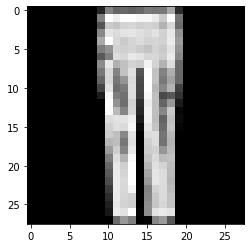

In [12]:
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")
# image是一个批量的图片，
# torch.Size([256, 1, 28, 28]) 256是batch_size，1是通道数，28*28图片长和宽
# plt.imshow()函数负责对图像进行处理，并显示其格式，但是不能显示。其后跟着plt.show（）才能显示出来，这里使用了魔术方法，而没有使用show()函数。cmap即colormaps,图谱。这里是灰度图

**模型设计**  
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构  
模型构建完成后，将模型放到GPU上用于训练  


In [13]:
? nn.Conv2d()

Object ` nn.Conv2d()` not found.


In [14]:
class Net(nn.Module):                       # 基于nn.Module来构建自己的模型
    def __init__(self):
        super(Net, self).__init__()        # 调用父类的__init__方法
        self.conv = nn.Sequential(         # 卷积层
            nn.Conv2d(1, 32, 5),           # 三个参数分别表示输入通道数、输出通道数、卷积核大小。其它参数使用默认值
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),              # 效果应该是有些值设为0
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(       # 全连接层
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)    #10类
        )
        
    def forward(self, x):           # forward函数调用__init__中定义的网络的各个块，串联起来
        x = self.conv(x)            # 使用网络Net时，会先对类进行实例化，此时参数传给__init__函数，然后使用对象此时参数传给forward
        x = x.view(-1, 64*4*4)      # flatten层，用来对数组进行展平操作。转换成一维然后传递给全连接层
        x = self.fc(x)              #此处没有加softmax，与损失函数的设计有关
        # x = nn.functional.normalize(x)
        return x

model = Net()    # 对类进行实例化
model = model.cuda()  # 需要放到gpu上的东西，都要使用.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解

**设定损失函数**  
使用torch.nn模块自带的CrossEntropy损失  
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss  
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [15]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])  对某个类别训练不满意，加重惩罚。

**设定优化器**  
这里我们使用Adam优化器  

In [16]:
optimizer = optim.Adam(model.parameters(), lr=LR)# 0.001

**训练和测试（验证）**  
各自封装成函数，方便后续调用  
关注两者的主要区别：  
- 模型状态设置  
- 是否需要初始化优化器
- 是否需要将loss传回到网络
- 是否需要每步更新optimizer  
  
此外，对于测试或验证过程，可以计算分类准确率

In [17]:
def train(epoch):
    model.train()
    train_loss = 0
    #i = 0
    for data, label in train_loader:           #for i,(data, label) in enumerate(train_loader):     这样写会返回batch的编号给i，同时还会返回batch的数据给data和label，是元组的形式。这里不需要对batch级别进行操作，所以没有这么写代码
        data, label = data.cuda(), label.cuda() # 由于模型已经放到gpu上了，所以data和label也需要放到gpu上，即.cuda()一下
        optimizer.zero_grad()                  # 由于自动求导会导致梯度累加，所以每个batch训练前需要进行梯度清零。放到loss.backward()前面即可
        output = model(data)                  # 进行前向传播
        loss = criterion(output, label)       # 损失函数计算，得到损失值
        loss.backward()                       # 将损失方向传播回去
        optimizer.step()                      # 使用优化器更新权值
        train_loss += loss.item()*data.size(0) # 训练损失的叠加，一个批量的损失*批量大小
        # print(data.size(0)) 256
        #i = i+1
        #print(i)  1-234 共234个batchsize  234*256=59904,每轮有96张图片未参加训练。三十进行平均时使用的是总的图片数60000
    train_loss = train_loss/len(train_loader.dataset) # 对训练损失进行平均。def __len__(self):返回的是有多少张图片.所有图片的损失除以图片的数量
    # print(len(train_loader.dataset)) 60000
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [18]:
def val(epoch):       # 使用验证集调整超参数。这里把测试集当做了验证集Validation set，测试集一般没有label          有点问题
    model.eval()      # Sets the module in evaluation mode.将模块设置为评估模式。Model类中没有test()方法
    val_loss = 0       # This is equivalent with self.train(False). 这等价于self.train(False)。
    gt_labels = []     # 真实的label
    pred_labels = []    # 预测的label
    with torch.no_grad():  # 不做梯度的计算   没有 optimizer.zero_grad()   loss.backward()   验证集不做参数的更新 optimizer.step()
        for data, label in test_loader: # 每一次for循环是在运行一个batch的数据。每次从test_loader中取出一个batch的数据，共40个batch（39+1）
            data, label = data.cuda(), label.cuda()
            output = model(data)                          # output256维，一共10类数据。传入一个batchsize的数据后，nn.mMoudle类默认返回神经网络的输出（预测）？Yes
            # print(output)                               # 定义好模型后，直接向model传入参数，就会执行forward方法，并返回forward方法的返回值
            # print(type(output))                         # <class 'torch.Tensor'>
            # print(output.shape)                         # torch.Size([256, 10] torch.Size([16, 10]) 39*256=9984 +16 =10000
            # print(len(label))                           # 39个256,1个16
            preds = torch.argmax(output, 1)               # argmax函数：torch.argmax(input, dim=None, keepdim=False) 返回指定维度最大值的序号
            gt_labels.append(label.cpu().data.numpy())    # list.append(obj) 参数 obj -- 添加到列表末尾的对象。
            pred_labels.append(preds.cpu().data.numpy())  # 将batch中的所有preds拼起来
            # print(pred_labels)                          # 注意列表初始值是[]，一个空列表。array的列表，[array([0...]), array([4...])] 一点点增加，最后列表中有40个array，对应40个batch。前39个array有256个数值，最后一个有16个数值
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
            # print(len(gt_labels)) # gt_labels是一个list 没有shpe、size属性
    val_loss = val_loss/len(test_loader.dataset)
    #print(len(pred_labels))  # pred_labels是list. 40，因为一个epoch有40个batch
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels) # np.concatenate() 是numpy中对array进行拼接的函数。默认axis=0，按照第一个维度进行拼接。将列表中的数组进行拼接。数组只有1个维度
    # print(pred_labels)
    # print(pred_labels.shape)    # (10000,)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)     # 验证过程可以计算一些指标，此处计算了精度
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [19]:
for epoch in range(1, epochs+1): # 20轮，之前定义的两个函数都是一轮所需执行的代码。def train(epoch): def val(epoch):  
    train(epoch)    # 可以把损失放在一个list里，进行可视化，画损失曲线
    val(epoch)     # 当训练损失下降，而验证损失不再下降或升高了，则停止训练
    # 此处是每一次训练都跟着一次验证，为了节省时间也可以多次训练，进行一次验证

Epoch: 1 	Training Loss: 0.678465
Epoch: 1 	Validation Loss: 0.430629, Accuracy: 0.847300
Epoch: 2 	Training Loss: 0.420630
Epoch: 2 	Validation Loss: 0.382222, Accuracy: 0.856100
Epoch: 3 	Training Loss: 0.365771
Epoch: 3 	Validation Loss: 0.308331, Accuracy: 0.888000
Epoch: 4 	Training Loss: 0.330908
Epoch: 4 	Validation Loss: 0.282218, Accuracy: 0.896800
Epoch: 5 	Training Loss: 0.309052
Epoch: 5 	Validation Loss: 0.270884, Accuracy: 0.901400
Epoch: 6 	Training Loss: 0.292429
Epoch: 6 	Validation Loss: 0.270518, Accuracy: 0.902600
Epoch: 7 	Training Loss: 0.278615
Epoch: 7 	Validation Loss: 0.243762, Accuracy: 0.913700
Epoch: 8 	Training Loss: 0.268869
Epoch: 8 	Validation Loss: 0.239764, Accuracy: 0.911000
Epoch: 9 	Training Loss: 0.255068
Epoch: 9 	Validation Loss: 0.236552, Accuracy: 0.912900
Epoch: 10 	Training Loss: 0.243315
Epoch: 10 	Validation Loss: 0.231612, Accuracy: 0.916500
Epoch: 11 	Training Loss: 0.236681
Epoch: 11 	Validation Loss: 0.222907, Accuracy: 0.917400
Epoch:

In [20]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)# 查看显存占用情况，当报出显存错误时有用。或者说别把卡的资源浪费了，看看显存占用情况，是否可以增大batchsize
print(gpu_info)

Fri Jun  3 10:38:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   1063MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**模型保存**  
训练完成后，可以使用torch.save保存模型参数或者整个模型，也可以在训练过程中保存模型  
这部分会在后面的课程中详细介绍

In [21]:
# save_path = "./FahionModel.pkl"
# torch.save(model, save_path) # 保存有多种，保存模型参数，还是保存整个模型，单卡还是多卡